# Starbucks Capstone Challenge

## Table of Content

####  [I. Problem Statement](#101)
####  [II. Data Sets](#102)
####  [III.: Data Cleaning](#103) 
####  [IV: Data Visualisation](#104) 
- [Among the Test Participants, How Many Offers are Viewed and Responded?](#104-1)  
- [How Long Does it Take for the Offer to be Viewed?](#104-2) 
- [What Types of Offer are Most Likely to be Responded?](#104-3) 
- [What is the General Demographics of Each Offer Type?](#104-4) 

####  [V:  Build Model](#105) 
- [Pre-processing Data for Modelling](#105-1) 
- [Model Training and Model Refinement Using Hyperparameter Tuning](#105-2) 
- [Feature Importance](#105-3) 

####  [VI: Conclusion](#106)  

# <a id = "101"> I. Problem Statement</a>

Data can tell a lot of stories about customer behaviour. Thanks to Big Data, we are able to have a better insight into purchase details, for example, what is the demographics of the customers who made the purchase, which products are the most popular in the region, or which offers attract the most customer responses. In this project, I am going to use the sample datasets of Starbucks data, provided by Udacity, to analyse the customer behaviour towards the Starbucks promotional offers, build a model to predict whether a customer will respond to an offer and suggest what features will motivate the customers to make the purchase with the offer.

To understand customer responses towards the promotional offers and analyse the most important features to drive their decisions, I am going to do the following steps:

- investigate the offer response stats of the sample customers
- identify the demographic groups for customers who respond to the viewed offer
- build a machine learning model to predict whether a customer will respond to an offer

## <a id = "102"> II. Data Sets</a>

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
%cd /Users/yc28/Desktop/Coding/Udacity_DS/starbucks_offer_ML/

/Users/yc28/Desktop/Coding/Udacity_DS/starbucks_offer_ML


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
% matplotlib inline


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, precision_recall_curve, classification_report, roc_auc_score


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# <a id = "103">III. Data Cleaning </a>

####  profile.json
- Remove customers with unknown age and gender 
- Fill NaN income with mean income values
- Change became_member_on column to date type

#### transcript.json
- change time unit from hour to day in order to match portfolio's duration column
- convert dict to list in value column
- create a separate column for the reward amount

In [6]:
def clean_profile(df):
    # Remove customers with unknown age and gender
    df = df[df.age != 118]
    df = df[~df.gender.isnull()]
    print('Removed customers with unknown age and gender')
    
    # Fill NaN income with mean income values
    df.income.fillna(df.income.mean(), inplace = True)
    print('Filled NaN income with mean income values')
    
    # Change became_member_on column to date type
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(x, format='%Y%m%d', errors='ignore'))
    print('Changed became_member_on column to date type')  
    print(' ')
    print('*** Cleaning process complete! ***')
    
    return df

In [7]:
profile_clean = clean_profile(profile)
profile_clean.shape

Removed customers with unknown age and gender
Filled NaN income with mean income values
Changed became_member_on column to date type
 
*** Cleaning process complete! ***


(14825, 5)

In [8]:
# verify unknown values have been dealt with
print('Customers with unknown age:', profile_clean[profile_clean.age==118].shape[0])
print('Customers with unknown gender', profile_clean.gender.isnull().sum())
print('Customers with unknown income',profile_clean.income.isnull().sum())

Customers with unknown age: 0
Customers with unknown gender 0
Customers with unknown income 0


In [9]:
def clean_transcript(df):
    # change time unit from hour to day in order to match portfolio's duration column
    df['time'] = round(df['time']/24,1)
    # convert dict to list in value column
    df['value'] = df['value'].apply(lambda x: list(x.values()))
    # create a separate column for the reward amount
    df[['value','reward']] = pd.DataFrame(df.value.tolist(), index= df.index)
    
    return df

In [10]:
transcript_clean = clean_transcript(transcript)

In [11]:
# create a new df, transcript_response, that records all offers received and their response
# new columns: key for person-offer id, offer viewed(int), offer responded time(int)
transcript_clean['key'] = transcript_clean['person']+'$'+ transcript_clean['value'].astype(str)
transcript_response = transcript_clean[transcript_clean.event == 'offer received']

In [12]:
transcript_clean[transcript_clean.person=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value,reward,key
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,78afa995795e4d85b5d9ceeca43f5fef$9b98b8c7a33c4...
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.2,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,78afa995795e4d85b5d9ceeca43f5fef$9b98b8c7a33c4...
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,5.5,19.89,NaN,78afa995795e4d85b5d9ceeca43f5fef$19.89
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.5,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,78afa995795e4d85b5d9ceeca43f5fef$9b98b8c7a33c4...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.0,17.78,NaN,78afa995795e4d85b5d9ceeca43f5fef$17.78
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,7.0,5a8bc65990b245e5a138643cd4eb9837,NaN,78afa995795e4d85b5d9ceeca43f5fef$5a8bc65990b24...
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9.0,5a8bc65990b245e5a138643cd4eb9837,NaN,78afa995795e4d85b5d9ceeca43f5fef$5a8bc65990b24...
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,9.2,19.67,NaN,78afa995795e4d85b5d9ceeca43f5fef$19.67
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,10.0,29.72,NaN,78afa995795e4d85b5d9ceeca43f5fef$29.72
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,15.8,23.93,NaN,78afa995795e4d85b5d9ceeca43f5fef$23.93


In [13]:
def get_offer_viewed(key, person, index):
    '''
    
    Mark whether the offer has been viewed, 
    if viewed, the value shows the number of days after the offer is received
    
    Args:
        key - the unique person-offer id combi
        index - the index number of the key
    
    Returns:
        offer_viewed - offer viewed results
        
            There are 3 types of results
            -1: if the first event is not offer received
            a number (float): the days between offer received and offer viewed
            99.99: if the offer is not viewed
            
        offer_responded - offer response
            1: responded
            0: not responded
        
    '''


    df = transcript_clean[(transcript_clean.key == key)&(transcript_clean.index >= index)]
    offer_responded = 0
    
    offer_id = df[df.index==index].value[index]
    expiry_day = portfolio[portfolio.id == offer_id].duration.values[0] + df[df.event=='offer received'].time.values[0]
    df_timed = transcript_clean[(transcript_clean.person == person)&(transcript_clean.time <= expiry_day)]
                
    try:

        if len(list(df.event)) >2: # check the event list is greater than 2 & 'offer viewed' is right after 'offer received'

            if list(df.event)[1] == 'offer viewed': # calculate offer viewed time
                offer_viewed = df[df.event=='offer viewed'].time.values[0] - df[df.event=='offer received'].time.values[0]

                if 'transaction' in list(df_timed.event): #  check transaction
                    offer_responded = 1

            else: # if the event list is smaller than 2, it means the offer is not viewed
                offer_viewed = 99.99
                
                if 'transaction' in list(df_timed.event):
                    offer_responded = 1

        else: 
            offer_viewed = 99.99 # offer not viewed
    except:
        print('Error with index:',index)
    
    print('Index {} processed'.format(index))
        
    
    return offer_viewed, offer_responded

In [55]:
transcript_response['offer_viewed'] = transcript_response.apply(lambda x: get_offer_viewed(x.key, x.person, x.name), axis=1)

In [15]:
def merge_dfs(response_df, portfolio_df, profile_df):
    
    # pre-clean response df: separate (0,1)
    response_df['offer_responded']=response_df['offer_viewed'].apply(lambda x: x[1])
    response_df['offer_viewed']=response_df['offer_viewed'].apply(lambda x: x[0])
    
    # combine portfolio_df with response_df
    merged_df = pd.merge(response_df,portfolio_df, left_on='value',right_on='id')
    merged_df = merged_df[['person','time','value','key','offer_viewed','offer_responded',
                                          'channels','difficulty','offer_type']]

    # combine with profile_df
    merged_df = pd.merge(merged_df, profile_df, how='left',
                                  left_on='person', right_on='id')
    
    # convert became_member_on column to datetime and calculate membership tenure
    today = pd.Timestamp.today().date()
    merged_df['tenure'] = merged_df['became_member_on'].apply(lambda x: round((today - pd.to_datetime(x).date()).days/365,1))
    
    # drop cols
    merged_df.drop(labels=['id','key','became_member_on'], axis=1, inplace=True)
    
    # fill NaNs
    merged_df.fillna(merged_df.mean(),inplace=True)
    
    return merged_df

In [16]:
transcript_response = merge_dfs(transcript_response, portfolio, profile_clean)

/Users/yc28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/yc28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# <a id = "104"> IV. Data Visualization <a/>

In this section, we aim to create data visualization to answer the following questions:

- Among the test participants, how many offers are viewed and responded?
- How long does it take for the offer to be viewed?
- What types of offer are most likely to be responded?
- What is the general demographics of each offer type?


#### <a id = "104-1"> Among the test participants, how many offers are viewed and responded? <a/>

#### <a id = "104-2">How long does it take for the offer to be viewed? <a/>

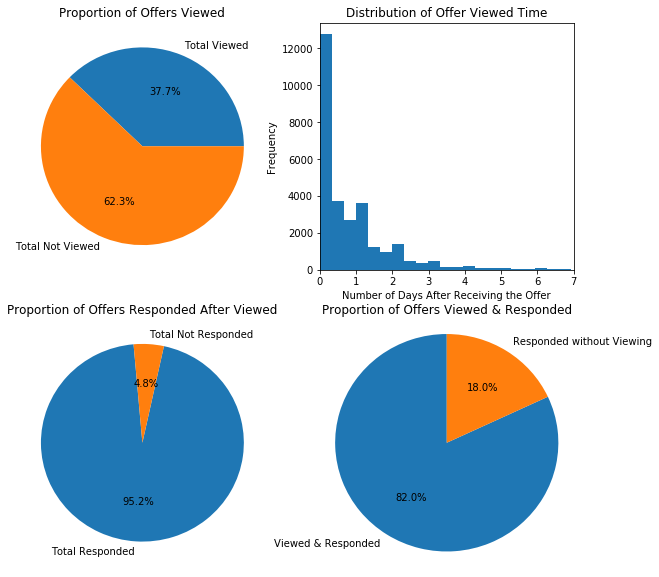

In [17]:
num_viewed = transcript_response[transcript_response.offer_viewed != 99.99].shape[0]
num_not_viewed = transcript_response[transcript_response.offer_viewed == 99.99].shape[0]

num_viewed_responded = transcript_response[(transcript_response.offer_viewed != 99.99)
                                   &(transcript_response.offer_responded == 1)].shape[0]
num_viewed_not_responded = transcript_response[(transcript_response.offer_viewed != 99.99)
                                       &(transcript_response.offer_responded != 1)].shape[0]

num_not_viewed_responded = transcript_response[(transcript_response.offer_viewed == 99.99)
                                       &(transcript_response.offer_responded == 1)].shape[0]


fig, ax = plt.subplots(2,2,figsize=[10,10])

# plot 1
ax[0,0].pie([num_viewed,num_not_viewed],labels=['Total Viewed','Total Not Viewed'],
           autopct='%1.1f%%')
ax[0,0].set_title('Proportion of Offers Viewed')

# plot 2
ax[1,0].pie([num_viewed_responded,num_viewed_not_responded],
            labels=['Total Responded','Total Not Responded'],
            autopct='%1.1f%%',startangle=95)
                       
ax[1,0].set_title('Proportion of Offers Responded After Viewed')


# plot 3
ax[1,1].pie([num_viewed_responded,num_not_viewed_responded],
            labels=['Viewed & Responded','Responded without Viewing'],
            autopct='%1.1f%%',startangle=90, radius=1.1)
                       
ax[1,1].set_title('Proportion of Offers Viewed & Responded')


# plot 4: How long does it take for the offer to be viewed?
ax[0,1].hist(transcript_response[transcript_response.offer_viewed != 99.99].offer_viewed, bins = 50)
ax[0,1].set_xlim([0,7])
ax[0,1].set_xlabel('Number of Days After Receiving the Offer')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of Offer Viewed Time')

plt.show()


From the above graphs, we can understand that:

- Of all the offers sent, 37.7% were viewed during the test.
- Majority of the participants viewed the offer within one day of receiving the offer.
- Of all the offers that have been viewed, 95.2% of the participants responded to the offer.
- Of all the offers that have been responded, 82.0% viewed the offer. The remaining 18.0% participants responded to the offer even they did not know the offer existed (i.e. they did not view the offer).

#### <a id = "104-3"> What types of offer are most likely to be responded? <a/>

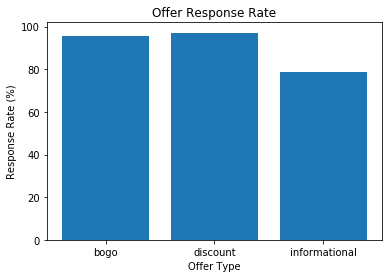

In [18]:
viewed_df = transcript_response[transcript_response.offer_viewed != 99.99]

viewed_responded_df = viewed_df[viewed_df.offer_responded ==1]

bogo_responded = viewed_responded_df[viewed_responded_df.offer_type=='bogo'].shape[0]/viewed_df[viewed_df.offer_type=='bogo'].shape[0]
discount_responded = viewed_responded_df[viewed_responded_df.offer_type=='discount'].shape[0]/viewed_df[viewed_df.offer_type=='discount'].shape[0]
info_responded = viewed_responded_df[viewed_responded_df.offer_type=='informational'].shape[0]/viewed_df[viewed_df.offer_type=='informational'].shape[0]

plt.bar(x=['bogo','discount','informational'],
        height=[bogo_responded*100,discount_responded*100,info_responded*100]
       )
plt.xlabel('Offer Type')
plt.ylabel('Response Rate (%)')
plt.title('Offer Response Rate')
plt.show()


From the above graph, it seems that discount offer has the highest response rate. This is followed by bogo, which has slightly lower response rate, however it is still over 90%. Informational offer has the lowest response rate with nearly 80%.



#### <a id = "104-4"> What is the general demographics of each offer type? <a/>

<Figure size 432x288 with 0 Axes>

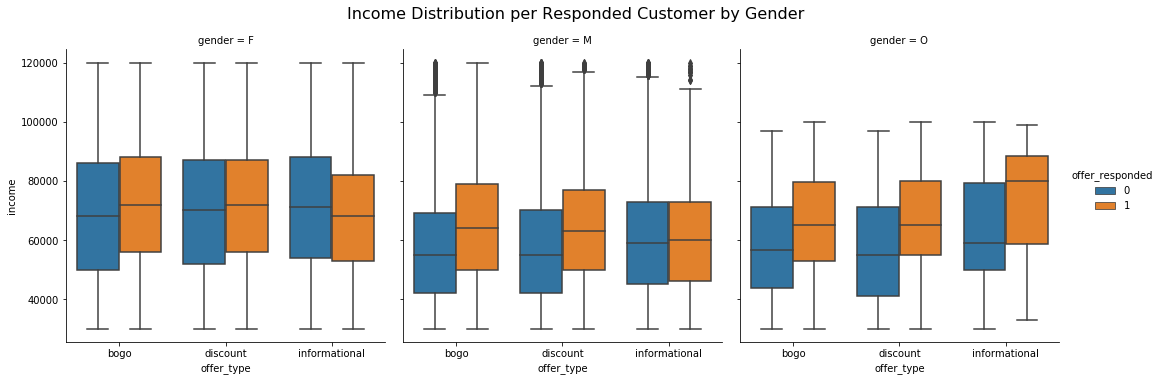

In [19]:
# income distribution of each responded offer type for each gender

plt.subplots_adjust(top=0.8)
g=sns.catplot(x="offer_type", y="income", col="gender", hue='offer_responded',
               data=transcript_response, kind='box')

g.fig.suptitle('Income Distribution per Responded Customer by Gender', fontsize=16,y=1.05)


plt.show()

/Users/yc28/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

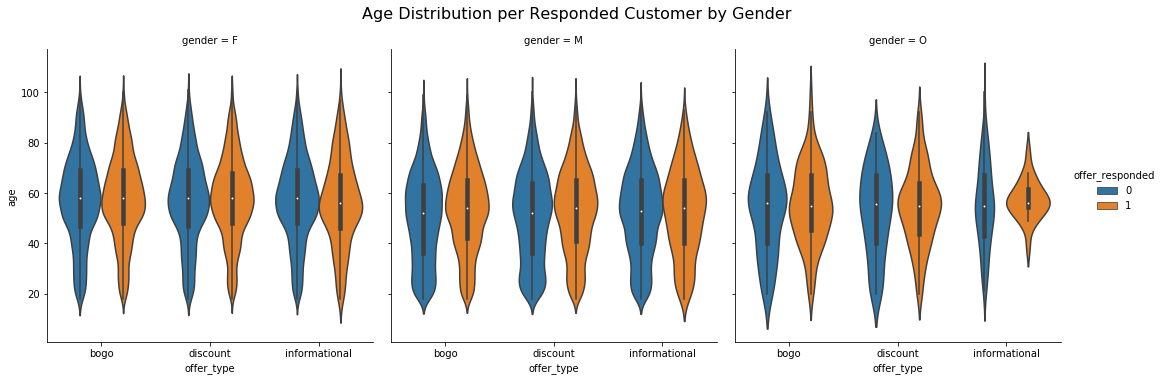

In [20]:
plt.subplots_adjust(top=0.8)
g=sns.catplot(x="offer_type", y="age", col="gender", hue='offer_responded',
               data=transcript_response, kind='violin')

g.fig.suptitle('Age Distribution per Responded Customer by Gender', fontsize=16,y=1.05)


plt.show()


<Figure size 432x288 with 0 Axes>

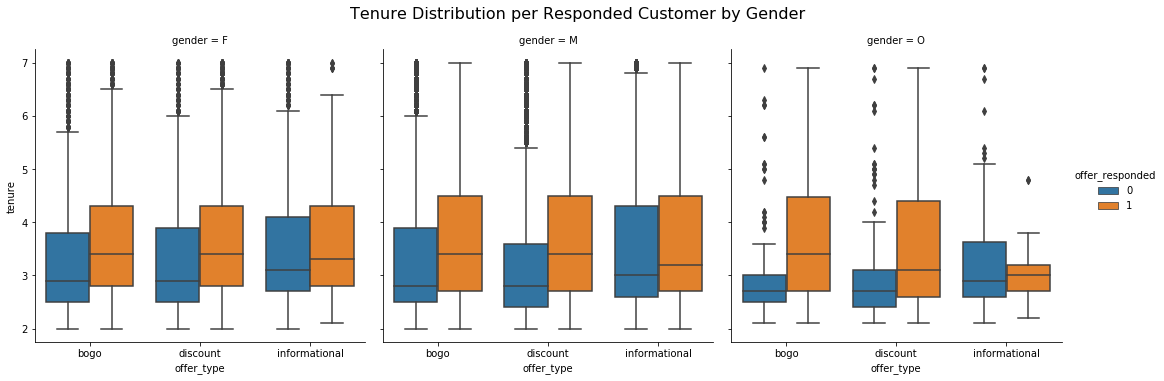

In [21]:
# tenure distribution of each responded offer type for each gender

plt.subplots_adjust(top=0.8)
g=sns.catplot(x="offer_type", y="tenure", col="gender", hue='offer_responded',
               data=transcript_response, kind='box')

g.fig.suptitle('Tenure Distribution per Responded Customer by Gender', fontsize=16,y=1.05)


plt.show()

From the above income, age and membership tenure distribution charts, we can understand that:

- Customers who responded to the offers tend to have slightly higher income (shown by higher mid point).
- Of the same income level, female customers are more likely to respond to the offers than other genders.
- There is no major difference in age for customers responded/did not respond to the offers.
- Customers with longer membership tenure tend to respond to the offers more than those who have lower tenure. This trend is significant across all genders.

# <a id = "105"> V. Build Model <a/>

In this section, we would like to use machine learning techniques to identify whether a customer will respond to an offer, and what are the most important features to determine a response. This will be done via the following steps:

- Pre-processing data for modelling
- Model training and model refinement using hyperparameter tuning
- Feature importance

#### <a id = "105-1">Pre-processing data for modelling <a/>

For data pre-processing, I am going to convert the categorical variables to dummies, and split the training and test datasets using train_test_split.

In [22]:
# Create a function that makes dummy columns for all categorical columns
def create_dummy_df(df, cat_cols, dummy_na=False):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis = 1), pd.get_dummies(df[col], prefix = col, prefix_sep = '_', 
                            drop_first = True, dummy_na = dummy_na)], axis = 1
                )
        except:
            pass
    return df

In [25]:
# Adjust the datasets for training purpose, and split train and test data

def preprocessing(df):
    # customers who respond to the offer without viewing are not in the scope of the promotion campaign 
    # Therefore we exclude them from the data
    df = df[~((df.offer_viewed ==99.99)&(df.offer_responded==1))]
    
    # drop unnecessary cols
    df.drop(labels=['person','time','value','offer_viewed'],axis=1, inplace=True)
    
    # convert channel col to col of strings, not lists
    df['channels']=df['channels'].astype(str)
    
    # convert offer_type, channels, gender to dummy cols
    df = create_dummy_df(df, ['offer_type', 'channels', 'gender'])

    # fill NaNs
    df.fillna(df.mean(),inplace=True)
    return df

In [26]:
model_data = preprocessing(transcript_response)

/Users/yc28/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/yc28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [27]:
# split train and test data
X = model_data.drop('offer_responded', axis = 1)
y = model_data['offer_responded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


#### <a id = "105-2"> Model training <a/>

In this section, I am going to apply the training data on the commonly used 2 machine learning models: random forest classifier and gradient boosting classifier. A brief overview of these models are as follows:

- Random forest classifier: randomly split the training data into several subsets with replacement. Each subset in the random forest generates a decision tree and a prediction result. The prediction result that the majority of decision trees points at is the final prediction outcome. 
 
 
- Gradient boosting classifier: iterates through a set of decision trees, taking the prediction result of previous decision tree and reflect in the target of the next tree so that it minimises prediction error. This model is good at minimising the model variance, however, it could be subject to the overfitting problem.


#### <a id = "105-3"> Model refinement using hyperparameter tuning <a/>

After identifying the suitable models, we would like to tune the model with hyperparameters. To search for the optimal parameters, I will define a set grid of parameters, and use RandomizedSeachCV to do the randomised search of the optimal combination of different parameters. I have set the number of iterations to be 50 and cv to be 3 to go over a fair amount of parameter combinations with the consideration of minimising the overfitting problem.

In [50]:
def randomized_search(modeltype, param_grid={}):
    model = RandomizedSearchCV(estimator=modeltype, 
                              param_distributions=param_grid, n_iter=50, cv=3, scoring='f1')

    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1:]
    precision, recall,thresholds = precision_recall_curve(y_test, y_scores)
    f1 = 2 * (precision * recall) / (precision + recall)
    best_f1_threshold = thresholds[np.argsort(-f1)[0]]
    y_preds = np.where(y_scores >= best_f1_threshold, 1, 0)
    
    
    print('Accuracy Score on Test Set: ', np.round(accuracy_score(y_test, y_preds), 2))
    print('Precision Score on Test Set: ', np.round(precision_score(y_test, y_preds), 2))
    print('Recall Score on Test Set: ', np.round(recall_score(y_test, y_preds), 2))
    print('F1 Score on Test Set', np.round(f1_score(y_test, y_preds), 2))
    
    return model

In [51]:
# create gradientboosting classifier
rf_param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 10],
    'min_samples_split' : [10, 100],
    'min_samples_leaf' : [10, 100],
    'n_estimators' : [50, 200, 300]
    
}


rf_model = randomized_search(RandomForestClassifier(random_state=42),param_grid=rf_param_grid)

Accuracy Score on Test Set:  0.74
Precision Score on Test Set:  0.63
Recall Score on Test Set:  0.79
F1 Score on Test Set 0.7


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 10], 'min_samples_split': [10, 100], 'min_samples_leaf': [10, 100], 'n_estimators': [50, 200, 300]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [52]:
# create gradientboosting classifier
gb_param_grid = {'loss': ['deviance', 'exponential'],
               'learning_rate': [0.1, 0.01, 0.001],
               'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
               'min_samples_leaf': [10,100],
               'min_samples_split': [10,100]}



gb_model = randomized_search(GradientBoostingClassifier(random_state=42), param_grid=gb_param_grid)

/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metric

/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metric

/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metric

Accuracy Score on Test Set:  0.73
Precision Score on Test Set:  0.62
Recall Score on Test Set:  0.8
F1 Score on Test Set 0.7


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300], 'min_samples_leaf': [10, 100], 'min_samples_split': [10, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

From the model training and refinement sections it can be seen that random forest model gives the higher accracy score and precision score, however, gradient boosting model has the higher for recall rate. Considering the F1 score is the same for the two models, it depends on whether precision weighs over recall, or vice versa. If the cost for sending out offers to customer is not considerably high, than Starbucks might want to target as many potential respondents as possibe, which means a high recall score is required. 

On the other hand, if the cost for sending out offers is too high, this means that Starbucks would not want to send out offers to customers who might ignore the offer. In this case, precision weighs over recall, then random forest model would be the choice. 

If we assume that Starbucks focuses more on precision, then random forest model would be the one we go for. If so, the most important features to determine the response from a customer are as follows:

#### <a id = "105-4"> Feature importance <a/>

Once the model is finalised, we would like to use the model to identify the most important features to motivate a customer to respond to the promotional offer.

In [53]:
model = rf_model

fi_dict = {
    'feature' : [],
    'importance' : []
}

features = model_data.columns[1:].tolist()

for feature, score in zip(features, model.best_estimator_.feature_importances_):
    fi_dict['feature'].append(feature)
    fi_dict['importance'].append(score)
    
    
fi_df = pd.DataFrame(fi_dict)

display(fi_df.sort_values(by=['importance'], ascending=False).head(5))

Accuracy Score on Test Set:  0.74
Precision Score on Test Set:  0.64
Recall Score on Test Set:  0.77
F1 Score on Test Set 0.7


,feature,importance
3,tenure,0.224024
6,"channels_['web', 'email', 'mobile', 'social']",0.206678
0,difficulty,0.152535
5,offer_type_informational,0.111510
2,income,0.108912


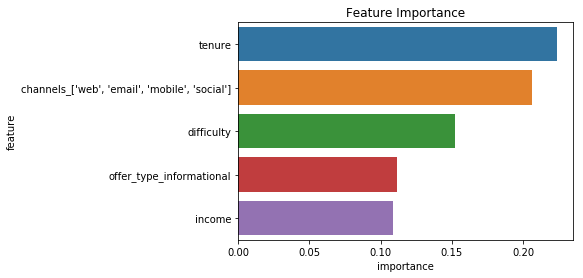

In [54]:
sns.barplot(y='feature', x='importance', data=fi_df.sort_values(by=['importance'], ascending=False).head(5), orient='h')
plt.title('Feature Importance')
plt.show()

From the above graph, it can be seen that tenure is the biggest determinant for a customer to respond to an offer. This makes sense intuitively, because if a customer is has been a regular Starbucks customer for a long time, he or she is very likely to use the offer to reduce the cost of purchase. Other features such as marketing channels (web, email mobile, social), difficulty in redeeming the offer, information offer and income level are also the top features to motivate a customer to make the offer.

# <a id = "106"> VI. Conclusion <a/>

The aim of this project is to analyse the customer behaviour towards the Starbucks promotional offers, predict whether a customer will respond to an offer and suggest what features will motivate the customers to make the purchase with the offer.

Through the data analysis, we understand that 37.7% of the customers viewed the offer sent, of which 95.2% responded to the offer. We also know that there appears to be no major difference in age for customers responded/did not respond to the offers. However, customers with longer membership tenure tend to respond to the offers more than those who have lower tenure. This trend is significant across all genders.

To predict whether a customer will respond to an offer, we first compare random forest classifier and gradient boosting classifier to see which model is better in terms of accuracy. Then we tune the model using optimal parameters powered by RandomizedSearchCV. Finally, we use this model to suggest the most important features for the prediction, for which tenure has the highest ranking.

For further improvement, there are several aspects to consider. For example, we did not use reward data in this analysis, which could inform a transaction decision depending the amount. Hence, future improvement could incorporate this aspect. In addition, there are other machine learning models such as bagging classifier which could provide decent result for prediction. It is worth testing out on those models as well, or use ensemble learning to combine several models for prediction. 